# Hello hello,
Welcome to the JQ Model Aquarium, the (future)? home of many models whose intelligence is comparable to the average goldfish

USING SGD with lr = 0.001 and momentum = 0.9

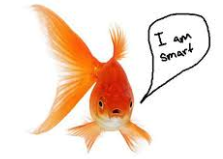

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()

In [2]:
print(use_gpu) #hallelujah

True


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

data_dir = '/home/jquach12/jq_shenanigans/data/blackAndWhite_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation','testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation','testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation','testing']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

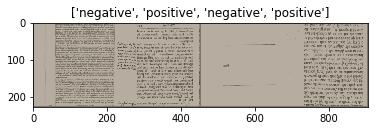

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [5]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================



trainLosses = []
valLosses = []
def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # looping parameters
        running_loss = 0.0
        
        
        confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'validation']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # Iterate over each book
            running_loss = 0.0
            
         
            confusion_matrix = tnt.meter.ConfusionMeter(2)
            for book in tqdm_notebook(data_loaders[phase]):
                for data in data_loaders[phase][book]:
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # back
                    if phase == 'train': 
                        loss.backward()
                        optimizer.step()

                    # Add to confusion matrix
                    confusion_matrix.add(outputs.data, labels.data)

                    # statistics
                   
                    running_loss += loss.item()
                    
            
            # report evaluation
            print('Phase:%s' %phase)
            print('Confusion matrix:\n', confusion_matrix.conf)
            if phase == 'train':
                print('train loss', running_loss)
                trainLosses.append(running_loss)
               
            else:
                print('validation loss', running_loss)
                valLosses.append(running_loss)
               
            
        
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
def plotLosses(trainLosses,valLosses,title = ""):
    plt.title(title)
    plt.plot(trainLosses,label = "training")
    plt.plot(valLosses,label = "validation")
    #plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

#plotLosses(trainLosses,valLosses,"JQ_MODEL")

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
        self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.conv3_drop = nn.Dropout2d(p = 0.1)
      
        #assumes a batch size of 50
        self.fc1 = nn.Linear(31360,64).cuda()
        self.fc2 = nn.Linear(64, 25).cuda()
        self.fc3 = nn.Linear(25,2).cuda()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [9]:
trainLosses = []
valLosses = []

trainAccs = []
valAccs = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    
    for epoch in range(num_epochs):
        cm_posAndNeg = tnt.meter.ConfusionMeter(2)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                if phase == 'validation':
                    cm_posAndNeg.add(outputs.data, labels.data)
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                trainLosses.append(epoch_loss)
                trainAccs.append(epoch_acc)
            elif phase == 'validation':
                valLosses.append(epoch_loss)
                valAccs.append(epoch_acc)
                
            if phase == 'validation':
                print('Confusion matrix:\n', cm_posAndNeg.conf)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model #got really high acc when if phase == 'val' i.e. this never happens
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
net1 = Net1()

In [12]:


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum = 0.9) #set lr a little high to decay later

# Decay LR by a factor of 0.9 every 25 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.9)

In [13]:
num_epochs = 100
net1 = train_model(net1, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 1/100
----------
train Loss: 0.6929 Acc: 0.5107
Confusion matrix:
 [[  0 168]
 [  0 168]]
validation Loss: 0.6915 Acc: 0.5000

Epoch 2/100
----------
train Loss: 0.6945 Acc: 0.5166
Confusion matrix:
 [[168   0]
 [168   0]]
validation Loss: 0.6921 Acc: 0.5000

Epoch 3/100
----------
train Loss: 0.6921 Acc: 0.5249
Confusion matrix:
 [[168   0]
 [168   0]]
validation Loss: 0.6904 Acc: 0.5000

Epoch 4/100
----------
train Loss: 0.6904 Acc: 0.5427
Confusion matrix:
 [[168   0]
 [168   0]]
validation Loss: 0.6927 Acc: 0.5000

Epoch 5/100
----------
train Loss: 0.6842 Acc: 0.5545
Confusion matrix:
 [[ 25 143]
 [  4 164]]
validation Loss: 0.6801 Acc: 0.5625

Epoch 6/100
----------
train Loss: 0.6796 Acc: 0.5818
Confusion matrix:
 [[139  29]
 [ 99  69]]
validation Loss: 0.6794 Acc: 0.6190

Epoch 7/100
----------
train Loss: 0.6634 Acc: 0.6102
Confusion matrix:
 [[ 25 143]
 [  2 166]]
validation Loss: 0.6663 Acc: 0.5685

Epoch 8/100
----------
train Loss: 0.6705 Acc: 0.5877
Confusion matri

Confusion matrix:
 [[140  28]
 [  7 161]]
validation Loss: 0.4063 Acc: 0.8958

Epoch 63/100
----------
train Loss: 0.4764 Acc: 0.7832
Confusion matrix:
 [[138  30]
 [  4 164]]
validation Loss: 0.3662 Acc: 0.8988

Epoch 64/100
----------
train Loss: 0.4946 Acc: 0.7879
Confusion matrix:
 [[133  35]
 [  9 159]]
validation Loss: 0.4210 Acc: 0.8690

Epoch 65/100
----------
train Loss: 0.4781 Acc: 0.7927
Confusion matrix:
 [[138  30]
 [ 13 155]]
validation Loss: 0.4227 Acc: 0.8720

Epoch 66/100
----------
train Loss: 0.4763 Acc: 0.7891
Confusion matrix:
 [[139  29]
 [  5 163]]
validation Loss: 0.3868 Acc: 0.8988

Epoch 67/100
----------
train Loss: 0.4731 Acc: 0.7938
Confusion matrix:
 [[136  32]
 [ 10 158]]
validation Loss: 0.4121 Acc: 0.8750

Epoch 68/100
----------
train Loss: 0.4629 Acc: 0.7796
Confusion matrix:
 [[137  31]
 [  6 162]]
validation Loss: 0.3988 Acc: 0.8899

Epoch 69/100
----------
train Loss: 0.4987 Acc: 0.7701
Confusion matrix:
 [[138  30]
 [  8 160]]
validation Loss: 0.4

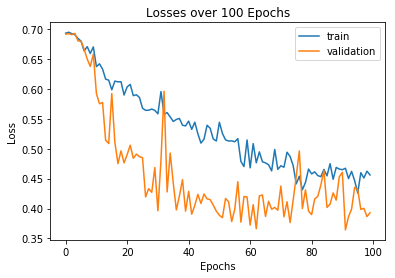

Some statistics of the last 20 epochs...

Average Training Loss: 0.4575651776292736
Average Validation Loss: 0.4142960018744426

Average Training Accuracy: 0.7938981042654029
Average Validation Accuracy: 0.8788690476190476

Lowest Training Loss found:0.4257965652510453


In [23]:
plt.plot(trainLosses,label = "train")
plt.plot(valLosses,label = "validation")
plt.title("Losses over " + str(num_epochs) +  " Epochs")
plt.ylabel('Loss')
plt.xlabel("Epochs")
plt.legend()
plt.show()

print("Some statistics of the last 20 epochs...")
print()
print("Average Training Loss: " + str(np.mean(trainLosses[80:])))
print("Average Validation Loss: " + str(np.mean(valLosses[80:])))
print()
print("Average Training Accuracy: " + str(np.mean(trainAccs[80:])))
print("Average Validation Accuracy: " + str(np.mean(valAccs[80:])))
print()
print("Lowest Training Loss found:" + str(np.min(trainLosses[80:])))

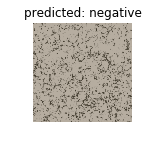

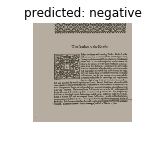

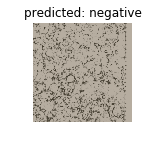

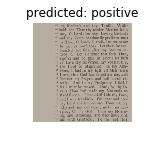

In [15]:
visualize_model(net1,4)

plt.ioff()
plt.show()

In [16]:
torch.save(net1.state_dict(), '/home/jquach12/net1_weight100ep.pt')
torch.save(net1, '/home/jquach12/net1_model100ep.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
